In [4]:
from sklearn.preprocessing import LabelEncoder
from preprocessor import Preprocessor

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joypy
from ast import literal_eval
from pandas.api.types import is_datetime64_any_dtype
from tqdm import tqdm

import warnings
import pickle

# Data Preprocessing

In [5]:
parquet = r'./preprocessed.parquet.gzip'
preprocessor = Preprocessor(parquet_path=parquet)
df = preprocessor.get_dataframe()
empties = df['query_template'] == ''
print(f"Removing {sum(empties)} empty query template values.")
df = df[:][~empties]
df.shape

df.to_csv("preprocessed.csv")

Removing 38 empty query template values.


In [6]:
groups = [(qt, gdf) for qt, gdf in df.groupby('query_template')]

selected_group = 25
query_template, gdf = groups[selected_group]
print(query_template)
display(gdf)

SELECT NO_O_ID FROM new_order WHERE NO_D_ID = $1 AND NO_W_ID = $2 ORDER BY NO_O_ID ASC LIMIT $3


query_template  \
log_time                                                                              
2022-03-08 11:29:38.190000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   
2022-03-08 11:29:38.191000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   
2022-03-08 11:29:38.191000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   
2022-03-08 11:29:38.192000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   
2022-03-08 11:29:38.192000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   
...                                                                             ...   
2022-03-08 11:29:41.836000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   
2022-03-08 11:29:41.836000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   
2022-03-08 11:29:41.837000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   
2022-03-08 11:29:41.837000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   
2022-03-08 11:29:41.838000-05:00  SELECT NO_O_ID FROM new_order WHERE NO_D_ID = ...   

                                    query_params  session_line_num  \
log_time                                                             
2022-03-08 11:29:38.190000-05:00   ('1', '1', 1)            480267   
2022-03-08 11:29:38.191000-05:00   ('2', '1', 1)            480274   
2022-03-08 11:29:38.191000-05:00   ('3', '1', 1)            480281   
2022-03-08 11:29:38.192000-05:00   ('4', '1', 1)            480288   
2022-03-08 11:29:38.192000-05:00   ('5', '1', 1)            480295   
...                                          ...               ...   
2022-03-08 11:29:41.836000-05:00   ('6', '1', 1)            529249   
2022-03-08 11:29:41.836000-05:00   ('7', '1', 1)            529256   
2022-03-08 11:29:41.837000-05:00   ('8', '1', 1)            529263   
2022-03-08 11:29:41.837000-05:00   ('9', '1', 1)            529270   
2022-03-08 11:29:41.838000-05:00  ('10', '1', 1)            529277   

                                 virtual_transaction_id  transaction_id  
log_time                                                                 
2022-03-08 11:29:38.190000-05:00                3/16698               0  
2022-03-08 11:29:38.191000-05:00                3/16698           56564  
2022-03-08 11:29:38.191000-05:00                3/16698           56564  
2022-03-08 11:29:38.192000-05:00                3/16698           56564  
2022-03-08 11:29:38.192000-05:00                3/16698           56564  
...                                                 ...             ...  
2022-03-08 11:29:41.836000-05:00                3/18392           58124  
2022-03-08 11:29:41.836000-05:00                3/18392           58124  
2022-03-08 11:29:41.837000-05:00                3/18392           58124  
2022-03-08 11:29:41.837000-05:00                3/18392           58124  
2022-03-08 11:29:41.838000-05:00                3/18392           58124  

[10550 rows x 5 columns]

In [7]:
# Extract parameters columns. Only deal with numerical or date parameters

# {key=template, value=params_dataframe}
query_to_df_original_map = {}
# {key=template, value=params_dataframe}
query_to_df_normalized_map = {}
# {key=template, value=[p1_dtype, p2_dtype, ...]}
query_to_dtype_map = {}
# {key=template, value=[(p1_mean, p1_var), (p2_mean, p2_var), ...]}
query_to_stats = {}

with warnings.catch_warnings():
  for index, (query_template, tdf) in enumerate(tqdm(df.groupby('query_template'))):

    # print(f"******************************************")
    # print(index, query_template)

    # Skip query templates with no parameters ex. BEGIN
    print(tdf['query_params'])
    if tdf['query_params'][0] == ():
        continue 
    
    # Extract param columns and strip off the quotation marks
    tdfp = tdf['query_params'].apply(pd.Series)
    tdfp = tdfp.apply(lambda col: col.str.strip("\"'"))

    # Make a copy of tdfp to store normalized version
    normalized_tdfp = tdfp.copy(deep=True)

    dtypes = []
    stats = []
    for j, col in enumerate(tdfp):
        try:
            tdfp[col] = pd.to_numeric(tdfp[col], errors='raise')
            normalized_tdfp[col] = pd.to_numeric(normalized_tdfp[col], errors='raise')
            dtypes.append("numerical")
        except:
            try:
                tdfp[col] = pd.to_datetime(tdfp[col], errors='raise')
                normalized_tdfp[col] = pd.to_datetime(normalized_tdfp[col], errors='raise')
                dtypes.append("date")
            except:
                # TODO: Right now we drop non date/numerical columns. Want to handle string columns later
                dtypes.append("string")
                pass

        # Compute mean/var and standardize the column
        if dtypes[-1] != "string":
            # print(f"param {j}, {dtypes[-1]}")
            mean = tdfp[col].mean()
            std = tdfp[col].std()
            # print(mean, std)
            # print(tdfp[col])
            if std != 0:
                normalized_tdfp[col] = (normalized_tdfp[col]-mean)/std
            else:
                normalized_tdfp[col] = (normalized_tdfp[col]-mean)
            stats.append((mean, std))
        else:
            stats.append(None)
    tdfp = tdfp.convert_dtypes()

    # Store df, dtype, and stats for this template
    query_to_df_original_map[query_template] = tdfp
    query_to_df_normalized_map[query_template] = normalized_tdfp
    query_to_dtype_map[query_template] = dtypes
    query_to_stats[query_template] = stats

  0%|          | 0/43 [00:00<?, ?it/s]

log_time
2022-03-08 11:29:38.155000-05:00    ()
2022-03-08 11:29:38.158000-05:00    ()
2022-03-08 11:29:38.161000-05:00    ()
2022-03-08 11:29:38.162000-05:00    ()
2022-03-08 11:29:38.165000-05:00    ()
                                    ..
2022-03-08 11:29:41.875000-05:00    ()
2022-03-08 11:29:41.881000-05:00    ()
2022-03-08 11:29:41.884000-05:00    ()
2022-03-08 11:29:41.887000-05:00    ()
2022-03-08 11:29:41.888000-05:00    ()
Name: query_params, Length: 26344, dtype: object
log_time
2022-03-08 11:29:38.154000-05:00    ()
2022-03-08 11:29:38.157000-05:00    ()
2022-03-08 11:29:38.160000-05:00    ()
2022-03-08 11:29:38.161000-05:00    ()
2022-03-08 11:29:38.164000-05:00    ()
                                    ..
2022-03-08 11:29:41.874000-05:00    ()
2022-03-08 11:29:41.877000-05:00    ()
2022-03-08 11:29:41.883000-05:00    ()
2022-03-08 11:29:41.886000-05:00    ()
2022-03-08 11:29:41.887000-05:00    ()
Name: query_params, Length: 26231, dtype: object
log_time
2022-03-08 11:29:

  7%|▋         | 3/43 [00:01<00:23,  1.74it/s]

log_time
2022-03-08 11:29:38.161000-05:00    ('6', '1', '2452', '6', '1', '2022-03-08 11:29...
2022-03-08 11:29:38.166000-05:00    ('1', '1', '351', '7', '1', '2022-03-08 11:29:...
2022-03-08 11:29:38.186000-05:00    ('7', '1', '1739', '7', '1', '2022-03-08 11:29...
2022-03-08 11:29:38.203000-05:00    ('3', '1', '731', '3', '1', '2022-03-08 11:29:...
2022-03-08 11:29:38.204000-05:00    ('4', '1', '167', '4', '1', '2022-03-08 11:29:...
                                                          ...                        
2022-03-08 11:29:41.846000-05:00    ('7', '1', '1314', '6', '1', '2022-03-08 11:29...
2022-03-08 11:29:41.850000-05:00    ('7', '1', '720', '7', '1', '2022-03-08 11:29:...
2022-03-08 11:29:41.865000-05:00    ('8', '1', '959', '8', '1', '2022-03-08 11:29:...
2022-03-08 11:29:41.872000-05:00    ('10', '1', '2147', '10', '1', '2022-03-08 11:...
2022-03-08 11:29:41.887000-05:00    ('6', '1', '1791', '6', '1', '2022-03-08 11:29...
Name: query_params, Length: 11290, dtype: obj

  9%|▉         | 4/43 [00:03<00:39,  1.01s/it]

log_time
2022-03-08 11:29:38.155000-05:00    ('4932', '10', '1')
2022-03-08 11:29:38.158000-05:00     ('4906', '4', '1')
2022-03-08 11:29:38.162000-05:00    ('4933', '10', '1')
2022-03-08 11:29:38.167000-05:00     ('4916', '6', '1')
2022-03-08 11:29:38.169000-05:00     ('4820', '9', '1')
                                           ...         
2022-03-08 11:29:41.873000-05:00     ('5035', '2', '1')
2022-03-08 11:29:41.875000-05:00     ('4972', '5', '1')
2022-03-08 11:29:41.881000-05:00     ('4894', '3', '1')
2022-03-08 11:29:41.885000-05:00     ('5000', '4', '1')
2022-03-08 11:29:41.888000-05:00     ('4998', '1', '1')
Name: query_params, Length: 11927, dtype: object


 12%|█▏        | 5/43 [00:05<00:47,  1.26s/it]

log_time
2022-03-08 11:29:38.155000-05:00    ('4932', '10', '1', '1913', '2022-03-08 11:29:...
2022-03-08 11:29:38.158000-05:00    ('4906', '4', '1', '2272', '2022-03-08 11:29:3...
2022-03-08 11:29:38.162000-05:00    ('4933', '10', '1', '1147', '2022-03-08 11:29:...
2022-03-08 11:29:38.167000-05:00    ('4916', '6', '1', '2205', '2022-03-08 11:29:3...
2022-03-08 11:29:38.169000-05:00    ('4820', '9', '1', '2993', '2022-03-08 11:29:3...
                                                          ...                        
2022-03-08 11:29:41.873000-05:00    ('5035', '2', '1', '1795', '2022-03-08 11:29:4...
2022-03-08 11:29:41.875000-05:00    ('4972', '5', '1', '755', '2022-03-08 11:29:41...
2022-03-08 11:29:41.881000-05:00    ('4894', '3', '1', '306', '2022-03-08 11:29:41...
2022-03-08 11:29:41.885000-05:00    ('5000', '4', '1', '371', '2022-03-08 11:29:41...
2022-03-08 11:29:41.888000-05:00    ('4998', '1', '1', '986', '2022-03-08 11:29:41...
Name: query_params, Length: 11926, dtype: obj

 14%|█▍        | 6/43 [00:07<00:54,  1.49s/it]

log_time
2022-03-08 11:29:38.156000-05:00    ('4932', '10', '1', '1', '3379', '1', '1', '6....
2022-03-08 11:29:38.156000-05:00    ('4932', '10', '1', '2', '81475', '1', '2', '9...
2022-03-08 11:29:38.156000-05:00    ('4932', '10', '1', '3', '2119', '1', '9', '81...
2022-03-08 11:29:38.156000-05:00    ('4932', '10', '1', '4', '27315', '1', '1', '1...
2022-03-08 11:29:38.156000-05:00    ('4932', '10', '1', '5', '69313', '1', '7', '8...
                                                          ...                        
2022-03-08 11:29:41.890000-05:00    ('4998', '1', '1', '5', '56421', '1', '1', '71...
2022-03-08 11:29:41.890000-05:00    ('4998', '1', '1', '6', '92903', '1', '5', '46...
2022-03-08 11:29:41.890000-05:00    ('4998', '1', '1', '7', '85606', '1', '7', '18...
2022-03-08 11:29:41.890000-05:00    ('4998', '1', '1', '8', '13980', '1', '5', '45...
2022-03-08 11:29:41.890000-05:00    ('4998', '1', '1', '9', '48823', '1', '7', '99...
Name: query_params, Length: 118399, dtype: ob

 40%|███▉      | 17/43 [00:25<00:31,  1.22s/it]

log_time
2022-03-08 11:29:38.794000-05:00    ()
2022-03-08 11:29:38.989000-05:00    ()
2022-03-08 11:29:39.541000-05:00    ()
2022-03-08 11:29:39.713000-05:00    ()
2022-03-08 11:29:03.844000-05:00    ()
                                    ..
2022-03-08 11:29:50.308000-05:00    ()
2022-03-08 11:29:50.487000-05:00    ()
2022-03-08 11:29:50.697000-05:00    ()
2022-03-08 11:29:40.416000-05:00    ()
2022-03-08 11:29:41.119000-05:00    ()
Name: query_params, Length: 114, dtype: object
log_time
2022-03-08 11:30:01.103000-05:00    ()
Name: query_params, dtype: object
log_time
2022-03-08 11:30:01.114000-05:00    ()
Name: query_params, dtype: object
log_time
2022-03-08 11:30:01.115000-05:00    ()
Name: query_params, dtype: object
log_time
2022-03-08 11:30:01.116000-05:00    ()
Name: query_params, dtype: object
log_time
2022-03-08 11:30:01.120000-05:00    ()
Name: query_params, dtype: object
log_time
2022-03-08 11:30:01.117000-05:00    ()
Name: query_params, dtype: object
log_time
2022-03-08 11:

 47%|████▋     | 20/43 [00:28<00:26,  1.13s/it]

log_time
2022-03-08 11:29:38.204000-05:00      ('1', '4', '167')
2022-03-08 11:29:38.210000-05:00      ('1', '9', '757')
2022-03-08 11:29:38.214000-05:00     ('1', '6', '1057')
2022-03-08 11:29:38.225000-05:00      ('1', '4', '195')
2022-03-08 11:29:38.247000-05:00     ('1', '9', '2191')
                                           ...         
2022-03-08 11:29:41.819000-05:00     ('1', '10', '299')
2022-03-08 11:29:41.820000-05:00     ('1', '5', '2175')
2022-03-08 11:29:41.823000-05:00     ('1', '4', '2043')
2022-03-08 11:29:41.871000-05:00    ('1', '10', '2147')
2022-03-08 11:29:41.887000-05:00     ('1', '6', '1791')
Name: query_params, Length: 4869, dtype: object


 51%|█████     | 22/43 [00:28<00:20,  1.01it/s]

log_time
2022-03-08 11:29:38.336000-05:00    ('1', '2')
2022-03-08 11:29:38.343000-05:00    ('1', '9')
2022-03-08 11:29:38.399000-05:00    ('1', '1')
2022-03-08 11:29:38.415000-05:00    ('1', '6')
2022-03-08 11:29:38.416000-05:00    ('1', '6')
                                       ...    
2022-03-08 11:29:41.544000-05:00    ('1', '9')
2022-03-08 11:29:41.545000-05:00    ('1', '6')
2022-03-08 11:29:41.651000-05:00    ('1', '8')
2022-03-08 11:29:41.653000-05:00    ('1', '1')
2022-03-08 11:29:41.693000-05:00    ('1', '7')
Name: query_params, Length: 1040, dtype: object
log_time
2022-03-08 11:29:38.155000-05:00    ('1', '10')
2022-03-08 11:29:38.158000-05:00     ('1', '4')
2022-03-08 11:29:38.162000-05:00    ('1', '10')
2022-03-08 11:29:38.167000-05:00     ('1', '6')
2022-03-08 11:29:38.169000-05:00     ('1', '9')
                                       ...     
2022-03-08 11:29:41.873000-05:00     ('1', '2')
2022-03-08 11:29:41.875000-05:00     ('1', '5')
2022-03-08 11:29:41.881000-05:00 

 53%|█████▎    | 23/43 [00:30<00:21,  1.08s/it]

log_time
2022-03-08 11:29:38.161000-05:00     ('1', '6')
2022-03-08 11:29:38.165000-05:00     ('1', '7')
2022-03-08 11:29:38.186000-05:00     ('1', '7')
2022-03-08 11:29:38.202000-05:00     ('1', '3')
2022-03-08 11:29:38.204000-05:00     ('1', '4')
                                       ...     
2022-03-08 11:29:41.846000-05:00     ('1', '6')
2022-03-08 11:29:41.850000-05:00     ('1', '7')
2022-03-08 11:29:41.865000-05:00     ('1', '8')
2022-03-08 11:29:41.871000-05:00    ('1', '10')
2022-03-08 11:29:41.887000-05:00     ('1', '6')
Name: query_params, Length: 11290, dtype: object


 56%|█████▌    | 24/43 [00:32<00:21,  1.15s/it]

log_time
2022-03-08 11:29:38.155000-05:00     ('3379',)
2022-03-08 11:29:38.155000-05:00    ('81475',)
2022-03-08 11:29:38.155000-05:00     ('2119',)
2022-03-08 11:29:38.155000-05:00    ('27315',)
2022-03-08 11:29:38.156000-05:00    ('69313',)
                                       ...    
2022-03-08 11:29:41.889000-05:00    ('56421',)
2022-03-08 11:29:41.889000-05:00    ('92903',)
2022-03-08 11:29:41.889000-05:00    ('85606',)
2022-03-08 11:29:41.889000-05:00    ('13980',)
2022-03-08 11:29:41.889000-05:00    ('48823',)
Name: query_params, Length: 119577, dtype: object


 58%|█████▊    | 25/43 [00:48<01:10,  3.91s/it]

log_time
2022-03-08 11:29:38.190000-05:00     ('1', '1', 1)
2022-03-08 11:29:38.191000-05:00     ('2', '1', 1)
2022-03-08 11:29:38.191000-05:00     ('3', '1', 1)
2022-03-08 11:29:38.192000-05:00     ('4', '1', 1)
2022-03-08 11:29:38.192000-05:00     ('5', '1', 1)
                                         ...      
2022-03-08 11:29:41.836000-05:00     ('6', '1', 1)
2022-03-08 11:29:41.836000-05:00     ('7', '1', 1)
2022-03-08 11:29:41.837000-05:00     ('8', '1', 1)
2022-03-08 11:29:41.837000-05:00     ('9', '1', 1)
2022-03-08 11:29:41.838000-05:00    ('10', '1', 1)
Name: query_params, Length: 10550, dtype: object


 63%|██████▎   | 27/43 [00:50<00:42,  2.67s/it]

log_time
2022-03-08 11:29:38.185000-05:00     ('1459', '7', '1')
2022-03-08 11:29:38.186000-05:00     ('2333', '4', '1')
2022-03-08 11:29:38.250000-05:00      ('401', '3', '1')
2022-03-08 11:29:38.261000-05:00     ('2573', '4', '1')
2022-03-08 11:29:38.276000-05:00     ('4962', '8', '1')
                                           ...         
2022-03-08 11:29:41.385000-05:00    ('2582', '10', '1')
2022-03-08 11:29:41.524000-05:00     ('4182', '7', '1')
2022-03-08 11:29:41.593000-05:00     ('2837', '6', '1')
2022-03-08 11:29:41.694000-05:00     ('4751', '6', '1')
2022-03-08 11:29:41.731000-05:00      ('246', '8', '1')
Name: query_params, Length: 1032, dtype: object
log_time
2022-03-08 11:29:38.190000-05:00     ('3830', '1', '1')
2022-03-08 11:29:38.191000-05:00     ('3830', '2', '1')
2022-03-08 11:29:38.191000-05:00     ('3830', '3', '1')
2022-03-08 11:29:38.192000-05:00     ('3830', '4', '1')
2022-03-08 11:29:38.192000-05:00     ('3830', '5', '1')
                                      

 67%|██████▋   | 29/43 [00:51<00:25,  1.80s/it]

log_time
2022-03-08 11:29:38.185000-05:00     ('1', '7', '119', 1)
2022-03-08 11:29:38.186000-05:00     ('1', '4', '302', 1)
2022-03-08 11:29:38.250000-05:00     ('1', '3', '463', 1)
2022-03-08 11:29:38.261000-05:00     ('1', '4', '478', 1)
2022-03-08 11:29:38.276000-05:00    ('1', '8', '2307', 1)
                                            ...          
2022-03-08 11:29:41.385000-05:00    ('1', '10', '119', 1)
2022-03-08 11:29:41.524000-05:00     ('1', '7', '170', 1)
2022-03-08 11:29:41.593000-05:00    ('1', '6', '2180', 1)
2022-03-08 11:29:41.694000-05:00     ('1', '6', '329', 1)
2022-03-08 11:29:41.731000-05:00     ('1', '8', '967', 1)
Name: query_params, Length: 1032, dtype: object
log_time
2022-03-08 11:29:38.191000-05:00     ('3830', '1', '1')
2022-03-08 11:29:38.191000-05:00     ('3830', '2', '1')
2022-03-08 11:29:38.191000-05:00     ('3830', '3', '1')
2022-03-08 11:29:38.192000-05:00     ('3830', '4', '1')
2022-03-08 11:29:38.192000-05:00     ('3830', '5', '1')
                

 70%|██████▉   | 30/43 [00:53<00:22,  1.71s/it]

log_time
2022-03-08 11:29:38.155000-05:00     ('3379', '1')
2022-03-08 11:29:38.155000-05:00    ('81475', '1')
2022-03-08 11:29:38.155000-05:00     ('2119', '1')
2022-03-08 11:29:38.156000-05:00    ('27315', '1')
2022-03-08 11:29:38.156000-05:00    ('69313', '1')
                                         ...      
2022-03-08 11:29:41.889000-05:00    ('56421', '1')
2022-03-08 11:29:41.889000-05:00    ('92903', '1')
2022-03-08 11:29:41.889000-05:00    ('85606', '1')
2022-03-08 11:29:41.889000-05:00    ('13980', '1')
2022-03-08 11:29:41.889000-05:00    ('48823', '1')
Name: query_params, Length: 119463, dtype: object


 72%|███████▏  | 31/43 [01:10<01:09,  5.83s/it]

log_time
2022-03-08 11:29:38.161000-05:00    ('1',)
2022-03-08 11:29:38.165000-05:00    ('1',)
2022-03-08 11:29:38.186000-05:00    ('1',)
2022-03-08 11:29:38.202000-05:00    ('1',)
2022-03-08 11:29:38.204000-05:00    ('1',)
                                     ...  
2022-03-08 11:29:41.846000-05:00    ('1',)
2022-03-08 11:29:41.849000-05:00    ('1',)
2022-03-08 11:29:41.865000-05:00    ('1',)
2022-03-08 11:29:41.871000-05:00    ('1',)
2022-03-08 11:29:41.887000-05:00    ('1',)
Name: query_params, Length: 11290, dtype: object


 74%|███████▍  | 32/43 [01:11<00:50,  4.58s/it]

log_time
2022-03-08 11:29:38.155000-05:00    ('1',)
2022-03-08 11:29:38.158000-05:00    ('1',)
2022-03-08 11:29:38.162000-05:00    ('1',)
2022-03-08 11:29:38.166000-05:00    ('1',)
2022-03-08 11:29:38.169000-05:00    ('1',)
                                     ...  
2022-03-08 11:29:41.872000-05:00    ('1',)
2022-03-08 11:29:41.875000-05:00    ('1',)
2022-03-08 11:29:41.881000-05:00    ('1',)
2022-03-08 11:29:41.884000-05:00    ('1',)
2022-03-08 11:29:41.888000-05:00    ('1',)
Name: query_params, Length: 11926, dtype: object


 77%|███████▋  | 33/43 [01:13<00:37,  3.71s/it]

log_time
2022-03-08 11:30:01.101000-05:00    ()
Name: query_params, dtype: object
log_time
2022-03-08 11:29:38.161000-05:00    ('-4919.58984375', '4919.58984375', '3', '1', ...
2022-03-08 11:29:38.165000-05:00    ('-7179', '29502.259765625', '13', '1', '1', '...
2022-03-08 11:29:38.186000-05:00    ('-4615.10009765625', '7079.79052734375', '6',...
2022-03-08 11:29:38.203000-05:00    ('-24717.669921875', '27673.41796875', '13', '...
2022-03-08 11:29:38.204000-05:00    ('29527.33203125', '15363.2607421875', '6', '1...
                                                          ...                        
2022-03-08 11:29:41.845000-05:00    ('-5374.60986328125', '5374.60986328125', '3',...
2022-03-08 11:29:41.846000-05:00    ('-3490.409912109375', '3490.409912109375', '2...
2022-03-08 11:29:41.850000-05:00    ('-11139.599609375', '11139.599609375', '4', '...
2022-03-08 11:29:41.871000-05:00    ('-5490.75', '12650.2001953125', '5', '1', '10...
2022-03-08 11:29:41.887000-05:00    ('4639.709960

 84%|████████▎ | 36/43 [01:14<00:12,  1.83s/it]

log_time
2022-03-08 11:29:38.212000-05:00    ('348.4501953125', '4623.919921875', '2', '189...
2022-03-08 11:29:38.218000-05:00    ('-4434.60009765625', '4434.60009765625', '2',...
2022-03-08 11:29:38.249000-05:00    ('205.389892578125', '3802.77001953125', '2', ...
2022-03-08 11:29:38.294000-05:00    ('-983.510009765625', '983.510009765625', '2',...
2022-03-08 11:29:38.424000-05:00    ('-1439.1099853515625', '1439.1099853515625', ...
                                                          ...                        
2022-03-08 11:29:41.731000-05:00    ('23047.259765625', '16420.501953125', '7', '2...
2022-03-08 11:29:41.793000-05:00    ('-15979.359375', '18418.91015625', '9', '703 ...
2022-03-08 11:29:41.804000-05:00    ('-61322.2109375', '61322.21875', '26', '479 2...
2022-03-08 11:29:41.823000-05:00    ('51095.26953125', '2739.35009765625', '3', '2...
2022-03-08 11:29:41.865000-05:00    ('-23308.12890625', '25533.08984375', '10', '9...
Name: query_params, Length: 1123, dtype: obje

 86%|████████▌ | 37/43 [01:16<00:10,  1.75s/it]

log_time
2022-03-08 11:29:38.155000-05:00    (1, '1', '10')
2022-03-08 11:29:38.158000-05:00     (1, '1', '4')
2022-03-08 11:29:38.162000-05:00    (1, '1', '10')
2022-03-08 11:29:38.167000-05:00     (1, '1', '6')
2022-03-08 11:29:38.169000-05:00     (1, '1', '9')
                                         ...      
2022-03-08 11:29:41.873000-05:00     (1, '1', '2')
2022-03-08 11:29:41.875000-05:00     (1, '1', '5')
2022-03-08 11:29:41.881000-05:00     (1, '1', '3')
2022-03-08 11:29:41.885000-05:00     (1, '1', '4')
2022-03-08 11:29:41.888000-05:00     (1, '1', '1')
Name: query_params, Length: 11926, dtype: object


 88%|████████▊ | 38/43 [01:17<00:08,  1.75s/it]

log_time
2022-03-08 11:29:38.161000-05:00     ('4522.97998046875', '1', '6')
2022-03-08 11:29:38.165000-05:00     ('4548.06982421875', '1', '7')
2022-03-08 11:29:38.186000-05:00    ('487.5400085449219', '1', '7')
2022-03-08 11:29:38.202000-05:00    ('342.9100036621094', '1', '3')
2022-03-08 11:29:38.204000-05:00      ('3403.6298828125', '1', '4')
                                                 ...               
2022-03-08 11:29:41.846000-05:00    ('3480.409912109375', '1', '6')
2022-03-08 11:29:41.850000-05:00      ('3474.5400390625', '1', '7')
2022-03-08 11:29:41.865000-05:00       ('4133.259765625', '1', '8')
2022-03-08 11:29:41.871000-05:00     ('3374.5400390625', '1', '10')
2022-03-08 11:29:41.887000-05:00    ('2521.590087890625', '1', '6')
Name: query_params, Length: 11290, dtype: object


 91%|█████████ | 39/43 [01:19<00:06,  1.68s/it]

log_time
2022-03-08 11:29:38.190000-05:00    ('10', '3830', '1', '1')
2022-03-08 11:29:38.191000-05:00    ('10', '3830', '2', '1')
2022-03-08 11:29:38.191000-05:00    ('10', '3830', '3', '1')
2022-03-08 11:29:38.192000-05:00    ('10', '3830', '4', '1')
2022-03-08 11:29:38.192000-05:00    ('10', '3830', '5', '1')
                                              ...           
2022-03-08 11:29:41.836000-05:00     ('4', '3883', '6', '1')
2022-03-08 11:29:41.837000-05:00     ('4', '3883', '7', '1')
2022-03-08 11:29:41.837000-05:00     ('4', '3883', '8', '1')
2022-03-08 11:29:41.837000-05:00     ('4', '3883', '9', '1')
2022-03-08 11:29:41.838000-05:00    ('4', '3883', '10', '1')
Name: query_params, Length: 10550, dtype: object


 93%|█████████▎| 40/43 [01:20<00:04,  1.63s/it]

log_time
2022-03-08 11:29:38.190000-05:00      ('2022-03-08 11:29:38.19', '3830', '1', '1')
2022-03-08 11:29:38.191000-05:00     ('2022-03-08 11:29:38.191', '3830', '2', '1')
2022-03-08 11:29:38.191000-05:00     ('2022-03-08 11:29:38.191', '3830', '3', '1')
2022-03-08 11:29:38.192000-05:00     ('2022-03-08 11:29:38.192', '3830', '4', '1')
2022-03-08 11:29:38.192000-05:00     ('2022-03-08 11:29:38.192', '3830', '5', '1')
                                                         ...                      
2022-03-08 11:29:41.836000-05:00     ('2022-03-08 11:29:41.836', '3883', '6', '1')
2022-03-08 11:29:41.837000-05:00     ('2022-03-08 11:29:41.837', '3883', '7', '1')
2022-03-08 11:29:41.837000-05:00     ('2022-03-08 11:29:41.837', '3883', '8', '1')
2022-03-08 11:29:41.838000-05:00     ('2022-03-08 11:29:41.838', '3883', '9', '1')
2022-03-08 11:29:41.838000-05:00    ('2022-03-08 11:29:41.838', '3883', '10', '1')
Name: query_params, Length: 10550, dtype: object


 95%|█████████▌| 41/43 [01:22<00:03,  1.61s/it]

log_time
2022-03-08 11:29:38.154000-05:00     ('39', '2', 1, '0', '24100', '1')
2022-03-08 11:29:38.154000-05:00     ('35', '8', 1, '0', '92609', '1')
2022-03-08 11:29:38.154000-05:00     ('45', '4', 1, '0', '24175', '1')
2022-03-08 11:29:38.154000-05:00     ('55', '4', 1, '0', '16006', '1')
2022-03-08 11:29:38.154000-05:00    ('55', '10', 1, '0', '87522', '1')
                                                   ...                
2022-03-08 11:29:41.886000-05:00     ('61', '1', 1, '0', '32455', '1')
2022-03-08 11:29:41.886000-05:00    ('65', '10', 1, '0', '71189', '1')
2022-03-08 11:29:41.886000-05:00    ('48', '10', 1, '0', '60118', '1')
2022-03-08 11:29:41.890000-05:00     ('72', '2', 1, '0', '56673', '1')
2022-03-08 11:29:41.890000-05:00     ('27', '6', 1, '0', '89670', '1')
Name: query_params, Length: 118399, dtype: object


 98%|█████████▊| 42/43 [01:39<00:06,  6.11s/it]

log_time
2022-03-08 11:29:38.161000-05:00     ('4522.97998046875', '1')
2022-03-08 11:29:38.165000-05:00     ('4548.06982421875', '1')
2022-03-08 11:29:38.186000-05:00    ('487.5400085449219', '1')
2022-03-08 11:29:38.202000-05:00    ('342.9100036621094', '1')
2022-03-08 11:29:38.204000-05:00      ('3403.6298828125', '1')
                                               ...            
2022-03-08 11:29:41.846000-05:00    ('3480.409912109375', '1')
2022-03-08 11:29:41.849000-05:00      ('3474.5400390625', '1')
2022-03-08 11:29:41.865000-05:00       ('4133.259765625', '1')
2022-03-08 11:29:41.871000-05:00      ('3374.5400390625', '1')
2022-03-08 11:29:41.887000-05:00    ('2521.590087890625', '1')
Name: query_params, Length: 11290, dtype: object


100%|██████████| 43/43 [01:40<00:00,  2.35s/it]


In [12]:
# Save the dictionaries
with open('./data/query_to_df_original_map.pickle', 'wb') as f:
    pickle.dump(query_to_df_original_map, f)

with open('./data/query_to_df_normalized_map.pickle', 'wb') as f:
    pickle.dump(query_to_df_normalized_map, f)

with open('./data/query_to_dtype_map.pickle', 'wb') as f:
    pickle.dump(query_to_dtype_map, f)

with open('./data/query_to_stats.pickle', 'wb') as f:
    pickle.dump(query_to_stats, f)

In [34]:
# with open('./data/query_to_df_map.pickle', 'rb') as f:
#   temp = pickle.load(f)
# temp["DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3"].head()

In [10]:
# for qt in query_to_df_map.keys():
#   print(qt)
#   print(query_to_df_original_map[qt].head())
#   print(query_to_df_normalized_map[qt].head())
#   print(query_to_dtype_map[qt],query_to_stats[qt])
#   print("*********************************\n")
#   break

DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3
                                     0  1  2
log_time                                    
2022-03-08 11:29:38.190000-05:00  3830  1  1
2022-03-08 11:29:38.191000-05:00  3830  2  1
2022-03-08 11:29:38.191000-05:00  3830  3  1
2022-03-08 11:29:38.192000-05:00  3830  4  1
2022-03-08 11:29:38.192000-05:00  3830  5  1
                                        0         1    2
log_time                                                
2022-03-08 11:29:38.190000-05:00  0.43997 -1.566625  0.0
2022-03-08 11:29:38.191000-05:00  0.43997 -1.218486  0.0
2022-03-08 11:29:38.191000-05:00  0.43997 -0.870347  0.0
2022-03-08 11:29:38.192000-05:00  0.43997 -0.522208  0.0
2022-03-08 11:29:38.192000-05:00  0.43997 -0.174069  0.0
['numerical', 'numerical', 'numerical'] [(3696.0, 304.5665649610596), (5.5, 2.8724174600239913), (1.0, 0.0)]
*********************************



In [14]:
def graph_query(index, query_to_df_map):
    qt = list(query_to_df_map.keys())[index]
    gdft = query_to_df_map[qt]
    print("Query:", qt)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, col in enumerate(gdft):
            meow = gdft[col].to_frame()
            try:
                joypy.joyplot(meow.groupby(pd.Grouper(freq="5s")), hist=True, bins=20, overlap=0, grid=True)
                print(f"PARAM ${i+1}")
                plt.show()
            except:
                pass


Query: DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3
PARAM $1


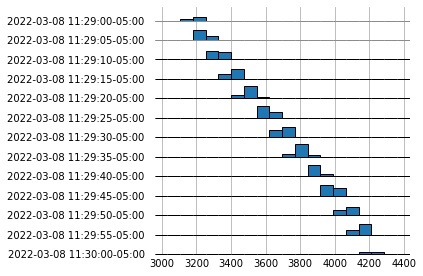

PARAM $2


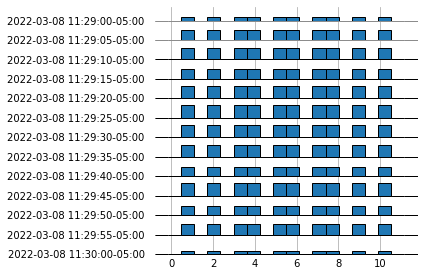

PARAM $3


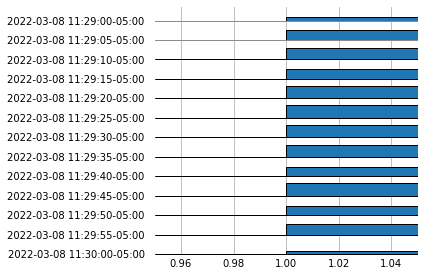

In [15]:
graph_query(0, query_to_df_original_map)

# Transform into Time-Series Data

In [16]:
# Each interval (time step) is vectorized into 4 bins --> [20, 40, 60, 80] percentiles
def left_boundary(x):
  return x.quantile(0.01)
def q1(x):
  return x.quantile(0.1)
def q2(x):
  return x.quantile(0.2)
def q3(x):
  return x.quantile(0.3)
def q4(x):
  return x.quantile(0.4)
def q5(x):
  return x.quantile(0.5)
def q6(x):
  return x.quantile(0.6)
def q7(x):
  return x.quantile(0.7)
def q8(x):
  return x.quantile(0.8)
def q9(x):
  return x.quantile(0.9)
def right_boundary(x):
  return x.quantile(0.99)

# quantiles = [q1, q2, q3, q4, q5, q6, q7, q8, q9]
quantiles = [left_boundary, q1, q2, q3, q4, q5, q6, q7, q8, q9, right_boundary]
quantile_names = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Prediction interval hyperparameters
prediction_interval = pd.Timedelta("2S") # Each interval has two seconds
prediction_seq_len = 5 # 5 data points
prediction_horizon = pd.Timedelta("2S")
# total time = interval * seq_len

In [205]:
# # X has shape (N, seq_len, num_quantiles) --> each training instance has shape (seq_len, num_quantiles) 
# # Y has shape (N, num_quantiles)
# X, Y = [], []
# for qt, tdfp in tqdm(query_to_df_map.items()):
#   dtypes = query_to_dtype_map[qt]
#   for j, col in enumerate(tdfp):
#     # Skip non-numerical columns
#     if dtypes[j] == "string":
#       continue

#     # Group by time and get quantile data
#     time_series_df = tdfp[col].resample(prediction_interval).agg(quantiles)
#     time_series_df = time_series_df.astype(float)
#     # display(time_series_df.head())
#     shifted = time_series_df.shift(freq=-prediction_horizon).reindex_like(time_series_df).ffill()

#     # Generate training instance. Add padding if neccesary
#     for i in range(len(time_series_df)):
#       if i+1 >= prediction_seq_len:
#         i_start = i - prediction_seq_len + 1
#         X.append(time_series_df.iloc[i_start:(i+1),:].to_numpy())
#         Y.append(time_series_df.iloc[i, :].to_numpy())
#       else:
#         x = time_series_df.iloc[:(i+1),:].to_numpy()
#         # Add padding above the rows
#         x = np.pad(x, ((prediction_seq_len-i-1, 0), (0, 0)))
#         X.append(x)
#         Y.append(time_series_df.iloc[i, :].to_numpy())
# X, Y = np.asarray(X), np.asarray(Y)
# print(X.shape, Y.shape)

100%|██████████| 31/31 [00:42<00:00,  1.37s/it]

(3330, 5, 11) (3330, 11)


In [14]:
# X has shape (N, seq_len, num_quantiles) --> each training instance has shape (seq_len, num_quantiles) 
# Y has shape (N, num_quantiles)
query_to_param_X = {}
query_to_param_Y = {}
for qt, tdfp in tqdm(query_to_df_normalized_map.items()):
  param_X = []
  param_Y = []

  dtypes = query_to_dtype_map[qt]
  for j, col in enumerate(tdfp):
    # Skip non-numerical columns
    if dtypes[j] == "string":
      param_X.append(None)
      param_Y.append(None)
      continue
    
    param_col_X = []
    param_col_Y = []
    # Group by time and get quantile data
    time_series_df = tdfp[col].resample(prediction_interval).agg(quantiles)
    time_series_df = time_series_df.astype(float)
    # display(time_series_df.head())
    shifted = time_series_df.shift(freq=-prediction_horizon).reindex_like(time_series_df).ffill()

    # Generate training instance. Add padding if neccesary
    for i in range(len(time_series_df)):
      if i+1 >= prediction_seq_len:
        i_start = i - prediction_seq_len + 1
        param_col_X.append(time_series_df.iloc[i_start:(i+1),:].to_numpy())
        param_col_Y.append(time_series_df.iloc[i, :].to_numpy())
      else:
        x = time_series_df.iloc[:(i+1),:].to_numpy()
        # Add padding above the rows
        x = np.pad(x, ((prediction_seq_len-i-1, 0), (0, 0)))
        param_col_X.append(x)
        param_col_Y.append(time_series_df.iloc[i, :].to_numpy())
    param_col_X, param_col_Y = np.asarray(param_col_X), np.asarray(param_col_Y)
    param_X.append(param_col_X)
    param_Y.append(param_col_Y)

  query_to_param_X[qt] = param_X
  query_to_param_Y[qt] = param_Y



100%|██████████| 31/31 [00:48<00:00,  1.57s/it]


In [19]:
# np.savez('param_training_data.npz', X=X, Y=Y)
with open('./data/query_to_param_X.pickle', 'wb') as f:
    pickle.dump(query_to_param_X, f)
with open('./data/query_to_param_Y.pickle', 'wb') as f:
    pickle.dump(query_to_param_Y, f)

# Playground

In [ ]:
gdft = gdf['query_params'].apply(literal_eval).apply(pd.Series)
# Remove unneccessary quation marks
gdft = gdft.apply(lambda col: col.str.strip("\"'"))
for col in gdft:
    try:
        gdft[col] = pd.to_datetime(gdft[col], errors='raise')
    except:
        try:
            gdft[col] = pd.to_numeric(gdft[col], errors='raise')
        except:
            pass
gdft = gdft.convert_dtypes()

print(gdft.dtypes)
display(gdft)


In [ ]:
# df = pd.read_csv("parsed_admission/postgres_parsed.csv", parse_dates=["log_time"], index_col=["log_time"])
# empties = df['query_template'] == ''
# print(f"Removing {sum(empties)} empty query template values.")
# df = df[:][~empties]
# print(df.shape)
# df.head()

Removing 0 empty query template values.
(37, 6)


session_id  session_line_num  \
log_time                                                   
2017-06-25 07:12:57.362167     4811356                 0   
2017-06-25 07:12:57.685996     4811357                 0   
2017-06-25 07:12:57.686190     4811357                 1   
2017-06-25 07:12:57.686832     4811357                 2   
2017-06-25 07:12:57.695170     4811357                 3   

                           virtual_transaction_id  transaction_id  \
log_time                                                            
2017-06-25 07:12:57.362167          AAC/4811356/0             NaN   
2017-06-25 07:12:57.685996          AAC/4811357/0             NaN   
2017-06-25 07:12:57.686190          AAC/4811357/1             NaN   
2017-06-25 07:12:57.686832          AAC/4811357/2             NaN   
2017-06-25 07:12:57.695170          AAC/4811357/3             NaN   

                                                               query_template  \
log_time                                                                        
2017-06-25 07:12:57.362167                                                NaN   
2017-06-25 07:12:57.685996                                                NaN   
2017-06-25 07:12:57.686190                                                NaN   
2017-06-25 07:12:57.686832  SELECT expdate,expdate2 FROM systemenv where d...   
2017-06-25 07:12:57.695170  select content from content where name= $1 and...   

                                                               query_params  
log_time                                                                     
2017-06-25 07:12:57.362167                                               ()  
2017-06-25 07:12:57.685996                                               ()  
2017-06-25 07:12:57.686190                                               ()  
2017-06-25 07:12:57.686832                                           ('1',)  
2017-06-25 07:12:57.695170  ("'15\\5d3afff71fda95c45e666b77095523a5'", '1')

In [97]:


def generate_ar_data(
    n_series: int = 10,
    timesteps: int = 400,
    seasonality: float = 3.0,
    trend: float = 3.0,
    noise: float = 0.1,
    level: float = 1.0,
    exp: bool = False,
    seed: int = 213,
) -> pd.DataFrame:
    """
    Generate multivariate data without covariates.

    Eeach timeseries is generated from seasonality and trend. Important columns:

    * ``series``: series ID
    * ``time_idx``: time index
    * ``value``: target value

    Args:
        n_series (int, optional): Number of series. Defaults to 10.
        timesteps (int, optional): Number of timesteps. Defaults to 400.
        seasonality (float, optional): Normalized frequency, i.e. frequency is ``seasonality / timesteps``.
            Defaults to 3.0.
        trend (float, optional): Trend multiplier (seasonality is multiplied with 1.0). Defaults to 3.0.
        noise (float, optional): Level of gaussian noise. Defaults to 0.1.
        level (float, optional): Level multiplier (level is a constant to be aded to timeseries). Defaults to 1.0.
        exp (bool, optional): If to return exponential of timeseries values. Defaults to False.
        seed (int, optional): Random seed. Defaults to 213.

    Returns:
        pd.DataFrame: data
    """
    # sample parameters
    np.random.seed(seed)
    linear_trends = np.random.normal(size=n_series)[:, None] / timesteps
    quadratic_trends = np.random.normal(size=n_series)[:, None] / timesteps**2
    seasonalities = np.random.normal(size=n_series)[:, None]
    levels = level * np.random.normal(size=n_series)[:, None]

    # generate series
    x = np.arange(timesteps)[None, :]
    print(linear_trends)
    print(x * linear_trends)
    print(seasonalities)
    # y = c*m1 * x + c* m2 * x^2 + m3 * sin(2pi*s*x/400)
    series = (x * linear_trends + x**2 * quadratic_trends) * trend + seasonalities * np.sin(
        2 * np.pi * seasonality * x / timesteps
    )
    # add noise
    series = levels * series * (1 + noise * np.random.normal(size=series.shape))
    if exp:
        series = np.exp(series)

    # insert into dataframe
    data = (
        pd.DataFrame(series)
        .stack()
        .reset_index()
        .rename(columns={"level_0": "series", "level_1": "time_idx", 0: "value"})
    )

    return data

temp = generate_ar_data(n_series=1, timesteps=400)
temp

[[0.00033711]]
[[0.         0.00033711 0.00067423 0.00101134 0.00134845 0.00168557
  0.00202268 0.0023598  0.00269691 0.00303402 0.00337114 0.00370825
  0.00404536 0.00438248 0.00471959 0.00505671 0.00539382 0.00573093
  0.00606805 0.00640516 0.00674227 0.00707939 0.0074165  0.00775361
  0.00809073 0.00842784 0.00876496 0.00910207 0.00943918 0.0097763
  0.01011341 0.01045052 0.01078764 0.01112475 0.01146186 0.01179898
  0.01213609 0.01247321 0.01281032 0.01314743 0.01348455 0.01382166
  0.01415877 0.01449589 0.014833   0.01517012 0.01550723 0.01584434
  0.01618146 0.01651857 0.01685568 0.0171928  0.01752991 0.01786702
  0.01820414 0.01854125 0.01887837 0.01921548 0.01955259 0.01988971
  0.02022682 0.02056393 0.02090105 0.02123816 0.02157527 0.02191239
  0.0222495  0.02258662 0.02292373 0.02326084 0.02359796 0.02393507
  0.02427218 0.0246093  0.02494641 0.02528353 0.02562064 0.02595775
  0.02629487 0.02663198 0.02696909 0.02730621 0.02764332 0.02798043
  0.02831755 0.02865466 0.02899178

series  time_idx     value
0         0         0  0.000000
1         0         1  0.036709
2         0         2  0.071428
3         0         3  0.111010
4         0         4  0.145110
..      ...       ...       ...
395       0       395  6.924453
396       0       396  6.222408
397       0       397  6.116891
398       0       398  5.736856
399       0       399  6.366929

[400 rows x 3 columns]

0      series  time_idx     value
0         0         0  0.000000
1         0         1  0.036709
2         0         2  0.071428
3         0         3  0.111010
4         0         4  0.145110
..      ...       ...       ...
395       0       395  6.924453
396       0       396  6.222408
397       0       397  6.116891
398       0       398  5.736856
399       0       399  6.366929

[400 rows x 3 columns]


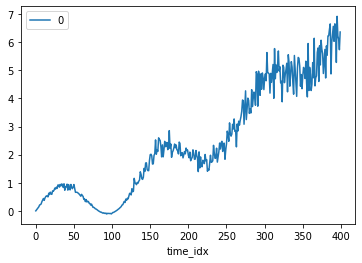

In [98]:
fig, ax = plt.subplots()

for key, grp in temp.groupby(['series']):
  print(key, grp)
  ax = grp.plot(ax=ax, kind='line', x='time_idx', y='value', label=key)

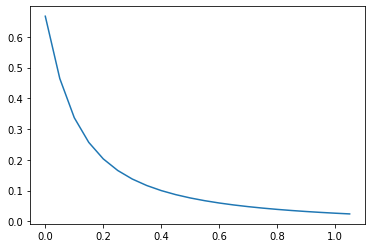

In [9]:
x = np.arange(0, 1.1, 0.05)
y = [0.6666666666497125, 0.464306062813326, 0.33699358974358906, 0.25676239799121137, 0.203173042454038, 0.16544961266137664, 0.1377376033057851, 0.11666820379934556, 0.10019489328828327, 0.087014741674964, 0.07626447057165271, 0.06735232904460933, 0.05986069651741288, 0.053487325579227425, 0.04800861569709535, 0.04325593148207255, 0.0390999070244219, 0.035439786531131376, 0.03219602609727163, 0.029305057737664914, 0.026715517965370496, 0.02438548764443781]

plt.plot(x, y)